In [1]:
import os
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy
import cartopy.feature as cfeature
import cartopy.util as cutil
import cmocean
import matplotlib
import matplotlib.animation as animation
import matplotlib.path as mpath
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable

SMALL_SIZE = 20
MEDIUM_SIZE = 20
BIGGER_SIZE = 24
styles = ["-", "--", "-.", ":", "-"]
plt.style.use("seaborn-whitegrid")
plt.rcParams["figure.figsize"] = [15, 10]
plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=SMALL_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("lines", linewidth=4)
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=plt.cm.Paired.colors)
# colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99']
colors = ['#d1e5f0','#67a9cf','#2166ac', '#fddbc7', '#ef8a62', '#b2182b']
# colors = ['#ffffcc','#c7e9b4','#7fcdbb','#41b6c4','#2c7fb8','#253494']
# colors = ['#c7e9b4','#7fcdbb','#41b6c4','#1d91c0','#225ea8','#0c2c84']
figlabels = ["a)", "b)", "c)", "d)", "e)", "f)", "g)", "h)"]

/glade/work/zespinosa/conda-envs/cenv/lib/python3.8/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.27.0
  warnings.warn(
ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/zespinosa/conda-envs/cenv/share/proj failed


In [6]:
si_nsidc = xr.open_dataset("/glade/work/zespinosa/Projects/SI-Antarctic/data/si_NSIDC_SH_si-anoms.nc")
si_cesm2 = xr.open_dataset("/glade/work/zespinosa/Projects/SI-Antarctic/data/si_CESM_SH_si-anoms.nc")

si_regions_nsidc = xr.open_dataset("/glade/work/zespinosa/Projects/SI-Antarctic/data/si_regions_NSIDC_anoms.nc")
si_regions_cesm2 = xr.open_dataset("/glade/work/zespinosa/Projects/SI-Antarctic/data/si_regions_CESM_anoms.nc")

<xarray.Dataset>
Dimensions:  (time: 900, region: 6)
Coordinates:
  * time     (time) datetime64[ns] 1950-01-15 1950-02-15 ... 2024-12-15
  * region   (region) object 'ross' 'amundsen' ... 'south_west_pacific'
Data variables:
    sia      (region, time) float64 ...
    sie      (region, time) float64 ...

## Figure 1 G and H

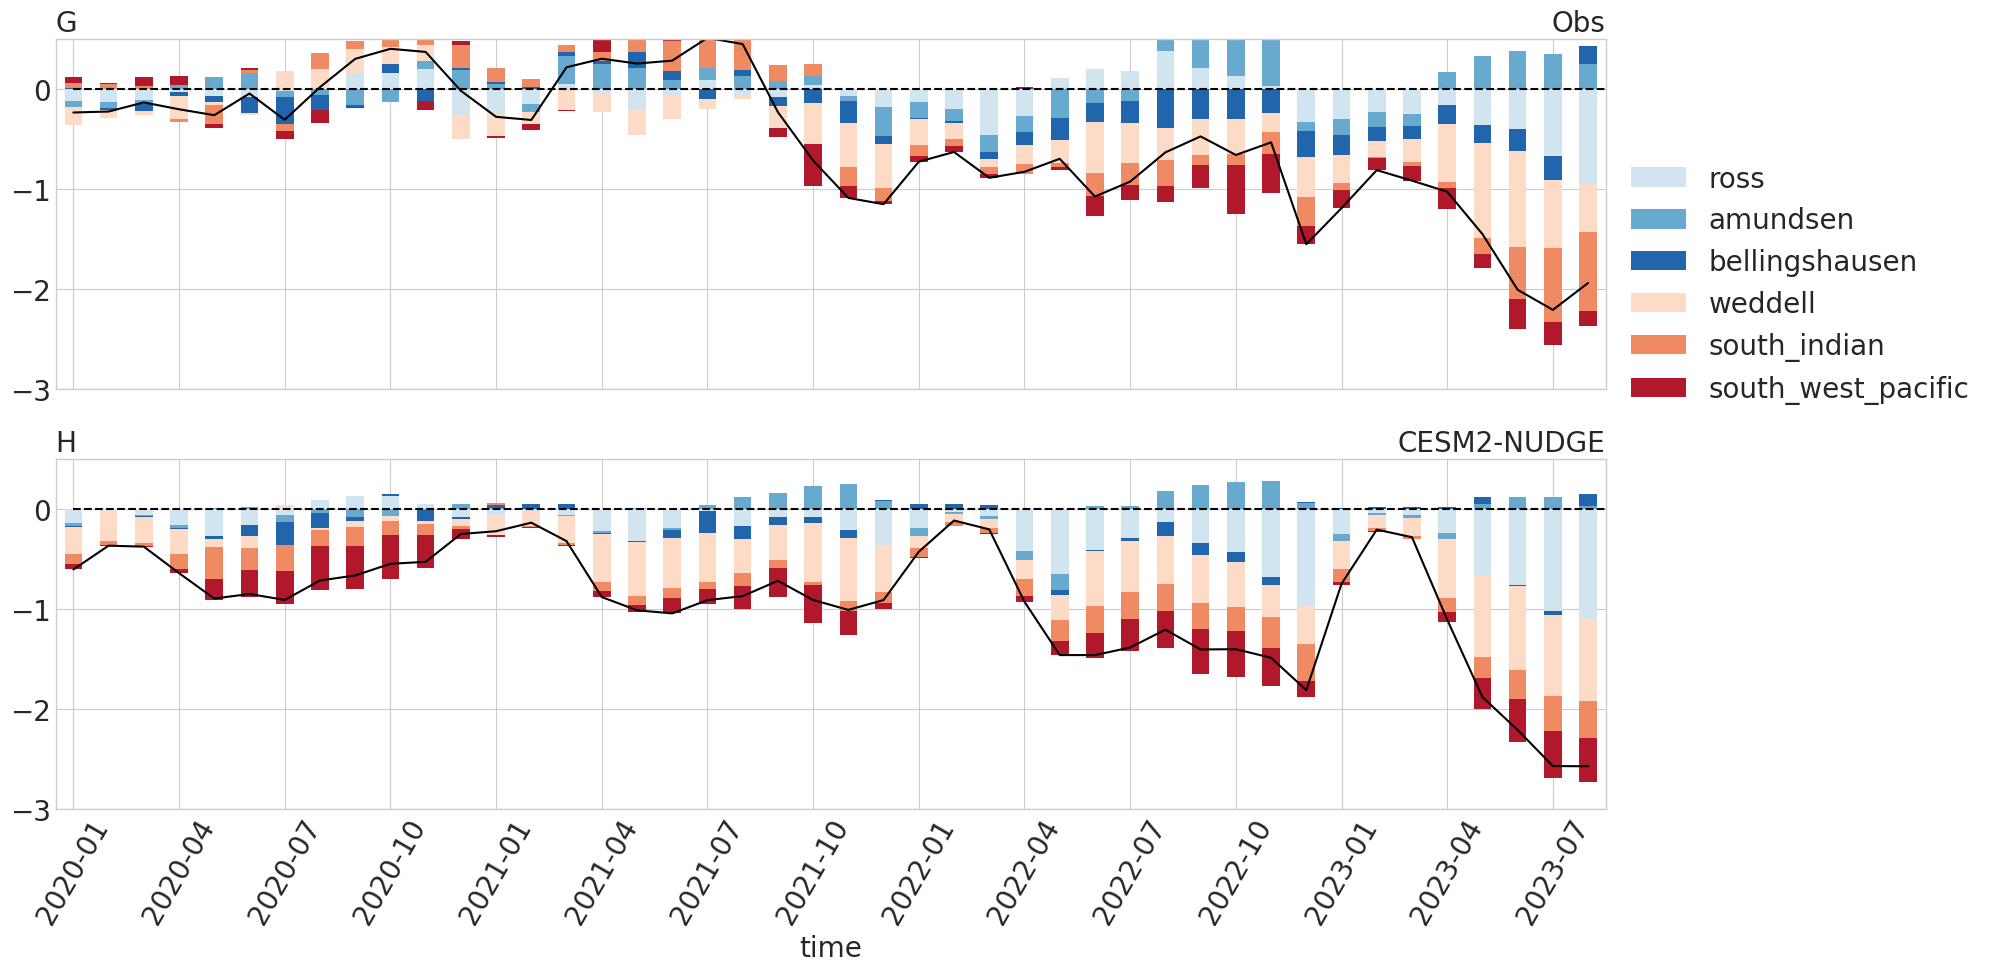

In [11]:
time_params = {
    "time_range": slice("2020-01-01", "2023-08-31"),
    "ticklabels": ["2020-01", "2020-04", "2020-07", "2020-10", "2021-01", "2021-04", "2021-07", "2021-10", "2022-01", "2022-04", "2022-07", "2022-10", "2023-01", "2023-04", "2023-07"],
}

def timeseries(time_params):
    linewidth = 1.5
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20,10), sharex=True)
    # Plot Line for NSIDC
    sia_nsidc = si_nsidc["sia"].sel(time=time_params["time_range"])
    ax1.hlines(0, xmin=0, xmax=len(sia_nsidc), color="black", linewidth=linewidth, linestyle="dashed")
    ax1.plot(sia_nsidc, color="black", linewidth=linewidth)
    # Plot Line for CESM2-NUDGE
    sia_cesm2= si_cesm2["sia"].sel(time=time_params["time_range"])
    ax2.hlines(0, xmin=0, xmax=len(sia_cesm2), color="black", linewidth=linewidth, linestyle="dashed")
    ax2.plot(sia_cesm2, color="black", linewidth=linewidth)

    # Plot Bar Charts for NSIDC
    sia_regions_nsidc = si_regions_nsidc["sia"].sel(time=time_params["time_range"])
    sia_regions_nsidc.to_pandas().T.plot.bar(ax=ax1, stacked=True, legend=False, color=colors)

    # Plot Bar Charts for CESM2-NUDGE
    sia_regions_cesm2 = si_regions_cesm2["sia"].sel(time=time_params["time_range"])
    sia_regions_cesm2.to_pandas().T.plot.bar(ax=ax2, stacked=True, legend=False, color=colors)

    # Add Styling
    ax2.set_xticks(np.arange(0, len(sia_nsidc), 3))
    ax2.set_xticklabels(time_params["ticklabels"], rotation=60)

    ax1.set_title(loc="right", label="Obs")
    ax1.set_title(loc="left", label="G")

    ax2.set_title(loc="right", label="CESM2-NUDGE")
    ax2.set_title(loc="left", label="H")

    ax1.set_ylim(-3, .5)
    ax2.set_ylim(-3, .5)

    plt.legend(loc='center left', bbox_to_anchor=(1.0, 1.5))
    plt.savefig("figures/Figure_1gh.png", dpi=400)

timeseries(time_params)

In [ ]:
# timeSlice = np.arange("2022-01", "2023-03", dtype="datetime64[M]")
# sia2023 = sianoms.sel(time=timeSlice, region=si.region[:-1])
# sia2023_total = sianoms.sel(time=timeSlice, region="total")
# sia2023.to_pandas().T.plot.bar(ax=ax1, stacked=True, legend=False, color=colors)
# ax1.plot(sia2023_total, color="black")
# ax1.set_title("2022-2023", loc="right", fontweight="bold")

# timeSlice = np.arange("2021-01", "2022-03", dtype="datetime64[M]")
# sia2022 = sianoms.sel(time=timeSlice, region=si.region[:-1])
# sia2022_total = sianoms.sel(time=timeSlice, region="total")
# sia2022.to_pandas().T.plot.bar(ax=ax2, stacked=True, legend=False, color=colors)
# ax2.plot(sia2022_total, color="black")
# ax2.set_title("2021-2022", loc="right", fontweight="bold")

# rects = ax2.patches[:len(timeSlice)]
# labels = np.array(sianoms_ranks.sel(time=timeSlice).values, dtype=int)
# for rect, label in zip(rects, labels): 
#     ax2.text(rect.get_x() + rect.get_width() / 2, .85, label, ha="center", va="bottom")

# timeSlice = np.arange("2017-01", "2018-03", dtype="datetime64[M]")
# sia2017 = sianoms.sel(time=timeSlice, region=si.region[:-1])
# sia2017_total = sianoms.sel(time=timeSlice, region="total")
# sia2017.to_pandas().T.plot.bar(ax=ax3, stacked=True, legend=False, color=colors)
# ax3.plot(sia2017_total, color="black")
# ax3.set_title("2016-2017", loc="right", fontweight="bold")

# rects = ax3.patches[:len(timeSlice)]
# labels = np.array(sianoms_ranks.sel(time=timeSlice).values, dtype=int)
# for rect, label in zip(rects, labels): 
#     ax3.text(rect.get_x() + rect.get_width() / 2, .75, label, ha="center", va="bottom")

# ax1.set_ylim(-2.3, 1.25)
# ax2.set_ylim(-2.3, 1.25)
# ax3.set_ylim(-2.3, 1.25)

# ax1.hlines(0, xmin=-2, xmax=15, linewidth=2, color="black")
# ax2.hlines(0, xmin=-2, xmax=15, linewidth=2, color="black")
# ax3.hlines(0, xmin=-2, xmax=15, linewidth=2, color="black")

# plt.legend(loc='center left', bbox_to_anchor=(1.0, 1.5))
# plt.xticks(ticks=np.arange(len(timeSlice)), labels=["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec", "Jan", "Feb"], rotation=45, fontweight="bold")
# ax2.set_ylabel(r"sea ice extent anomaly ($10^6$km$^2$)", fontweight="bold")
# plt.xlabel("")